In [1]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence
from glob import glob

class ClearGraspDataGenerator(Sequence):
    def __init__(self, image_paths, edge_paths, batch_size=32, img_size=(128, 128), shuffle=True):
        super().__init__()
        # 개수 맞추기
        min_len = min(len(image_paths), len(edge_paths))
        self.image_paths = sorted(image_paths[:min_len])
        self.edge_paths = sorted(edge_paths[:min_len])

        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = [], []

        for i in batch_idx:
            img = cv2.imread(self.image_paths[i]) / 255.0
            img = cv2.resize(img, self.img_size)

            edge = cv2.imread(self.edge_paths[i], cv2.IMREAD_GRAYSCALE)
            edge = cv2.resize(edge, self.img_size)

            edge_mask = np.zeros_like(edge)
            edge_mask[edge == 1] = 1   # Occlusion edge
            edge_mask[edge == 2] = 2   # Contact edge
            edge_mask = np.expand_dims(edge_mask, axis=-1)


            X.append(img)
            Y.append(edge_mask)

        return np.array(X), np.array(Y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [5]:
from glob import glob

# 전체 파일 경로 수집
import itertools
from glob import glob

#초과 문제로 3천장만 불러와서 테스트
train_imgs = list(itertools.islice(sorted(glob('/content/drive/MyDrive/Cleargrasp_Dataset/train/images/*.jpg')), 3000))
train_edges = list(itertools.islice(sorted(glob('/content/drive/MyDrive/Cleargrasp_Dataset/train/outlines/outline/*.png')), 3000))

val_imgs = sorted(glob('/content/drive/MyDrive/Cleargrasp_Dataset/val/image/images/*.jpg'))
val_edges = sorted(glob('/content/drive/MyDrive/Cleargrasp_Dataset/val/outlines/outline/*.png'))

# train 3천장 제한
train_imgs = train_imgs[:3000]
train_edges = train_edges[:3000]

#Generator 생성
train_gen = ClearGraspDataGenerator(train_imgs, train_edges, batch_size=8, img_size=(96, 96))
val_gen   = ClearGraspDataGenerator(val_imgs, val_edges, batch_size=8, img_size=(96, 96), shuffle=False)


In [ ]:
'''
import itertools
from glob import glob

train_imgs = list(itertools.islice(sorted(glob('/content/drive/MyDrive/Cleargrasp_Dataset/train/images/*.jpg')), 3000))
train_edges = list(itertools.islice(sorted(glob('/content/drive/MyDrive/Cleargrasp_Dataset/train/outlines/outline/*.png')), 3000))

# 전체 파일 경로 수집
train_imgs = sorted(glob('/content/drive/MyDrive/Cleargrasp_Dataset/train/images/*.jpg'))
train_edges = sorted(glob('/content/drive/MyDrive/Cleargrasp_Dataset/train/outlines/outline/*.png'))
'''

In [6]:
#배치 확인
print(f"Train generator length: {len(train_gen)}")
print(f"Validation generator length: {len(val_gen)}")

Train generator length: 375
Validation generator length: 67


In [7]:
#외곽선 존재여부 확인
import cv2
import numpy as np
import matplotlib.pyplot as plt

sample_edge_path = '/content/drive/MyDrive/Cleargrasp_Dataset/val/outlines/outline/stemless-plastic-champagne-glass-val(117).png'  # 실제 파일명 하나 넣기
edge = cv2.imread(sample_edge_path, cv2.IMREAD_GRAYSCALE)

unique_vals = np.unique(edge)
print("고유 픽셀 값들:", unique_vals)


고유 픽셀 값들: [0 1 2]


In [9]:
#엣지 제대로 변환됐나 확인
X, Y = train_gen[0]   # 첫 번째 배치 호출

print("X shape:", X.shape)           # (batch, height, width, 3)
print("Y shape:", Y.shape)           # (batch, height, width, 1)
print("Y dtype:", Y.dtype)

print("Unique labels in Y[0]:", np.unique(Y[0]))
# 예시 출력: [0 1 2] 이면 정상 (배경, occlusion, contact 순서)


X shape: (8, 96, 96, 3)
Y shape: (8, 96, 96, 1)
Y dtype: uint8
Unique labels in Y[0]: [0 1 2]


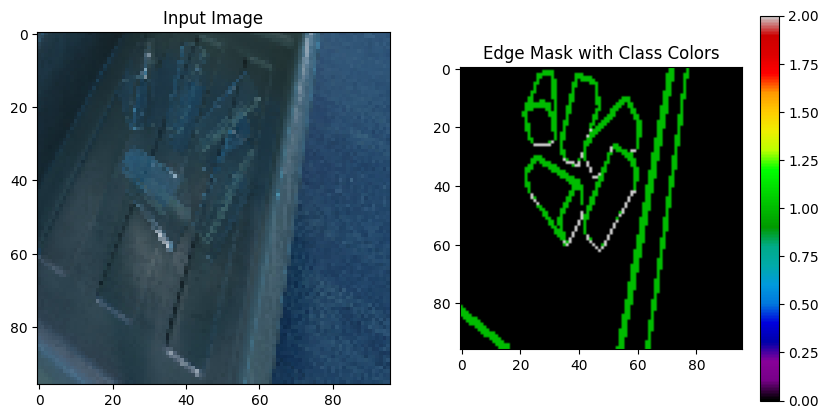

In [10]:
#엣지가 제대로 매핑됐나 확인

# 학습 배치 하나 불러오기
X_batch, Y_batch = train_gen[0]

# Edge Mask 시각화 (0: 배경, 1: Occlusion, 2: Contact)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(X_batch[0])
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(Y_batch[0].squeeze(), cmap='nipy_spectral')
plt.title("Edge Mask with Class Colors")
plt.colorbar()

plt.show()

#하얀색 : Contact /  #초록색 : Occlusion

In [11]:
#Unet 모델 정의(속도 문제로 경량화 버전으로 테스트)
from tensorflow.keras import layers, models

def build_light_unet(input_shape=(96, 96, 3), num_classes=3):  #0:배경, 1:Occlusion 2:Contact -> 클래스 3개로 지정
    inputs = layers.Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
        return x

    def encoder_block(x, filters):
        f = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(f)
        return f, p

    def decoder_block(x, skip, filters):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    f1, p1 = encoder_block(inputs, 32)
    f2, p2 = encoder_block(p1, 64)
    f3, p3 = encoder_block(p2, 128)

    bottleneck = conv_block(p3, 256)

    d3 = decoder_block(bottleneck, f3, 128)
    d2 = decoder_block(d3, f2, 64)
    d1 = decoder_block(d2, f1, 32)

    #다중 클래스: softmax + num_classes=3
    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(d1)

    model = models.Model(inputs, outputs)
    return model



In [ ]:
'''
import tensorflow as tf

# 모델 정의
model = build_light_unet(input_shape=(96, 96, 3), num_classes=3)

# 모델 컴파일 (loss 함수 명시적으로 지정)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
'''

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. 모델 정의
model = build_light_unet(input_shape=(96, 96, 3), num_classes=3)

# 2. 클래스 가중치
weights = tf.constant([1.0, 3.0, 8.0], dtype=tf.float32)

# 3. 커스텀 손실 함수
def loss_fn(y_true, y_pred):
    # (batch, 96, 96, 1) → (batch, 96, 96)
    y_true = tf.squeeze(y_true, axis=-1)

    # 정수형 변환 + one-hot
    y_true = tf.cast(y_true, tf.int32)
    y_true_onehot = tf.one_hot(y_true, depth=3)  # (batch, 96, 96, 3)

    # categorical crossentropy
    loss = tf.keras.losses.categorical_crossentropy(y_true_onehot, y_pred)

    # 가중치 적용
    weight_map = tf.reduce_sum(weights * y_true_onehot, axis=-1)
    weighted_loss = loss * weight_map

    return tf.reduce_mean(weighted_loss)

# 4. 컴파일
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])


In [13]:
# 한 배치 출력해보고 확인
X, Y = train_gen[0]
print(Y.shape)  # (batch, 96, 96, 1)


(8, 96, 96, 1)


In [14]:
history = model.fit(train_gen, validation_data=val_gen, epochs=30)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 3603s 10s/step - accuracy: 0.9474 - loss: 0.5950 - val_accuracy: 0.9682 - val_loss: 0.3755
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 283ms/step - accuracy: 0.9468 - loss: 0.5045 - val_accuracy: 0.9662 - val_loss: 0.2863
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 282ms/step - accuracy: 0.9426 - loss: 0.4346 - val_accuracy: 0.9659 - val_loss: 0.2777
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 283ms/step - accuracy: 0.9425 - loss: 0.4034 - val_accuracy: 0.9653 - val_loss: 0.2431
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 108s 288ms/step - accuracy: 0.9427 - loss: 0.3853 - val_accuracy: 0.9541 - val_loss: 0.2604
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 282ms/step - accuracy: 0.9425 - loss: 0.3631 - val_accuracy: 0.9594 - val_loss: 0.2488
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 281ms/step - accuracy: 0.9416 - loss: 0.3587 - val_accuracy: 0.9598 - val_loss: 0.2350
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 281ms/step - accuracy: 0.9424 - 

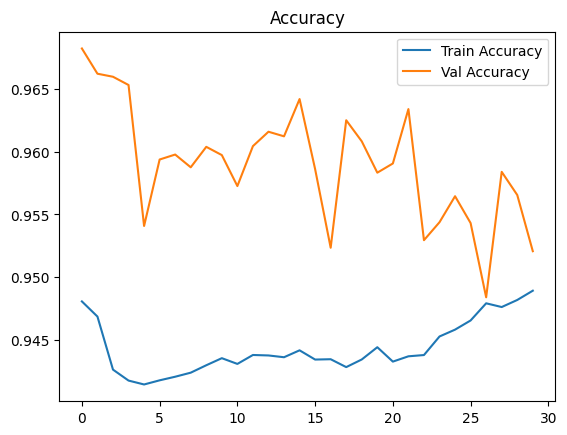

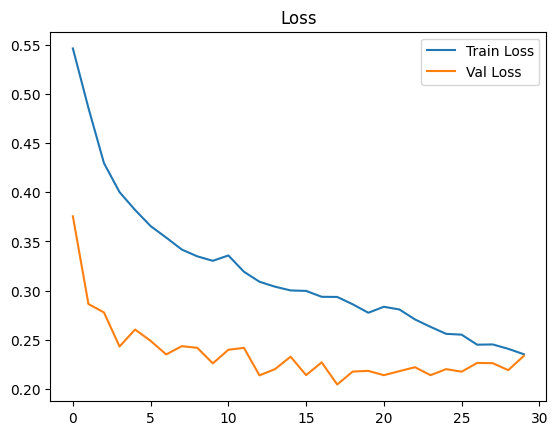

In [15]:
#학습결과 시각화
import matplotlib.pyplot as plt

#정확도 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

#손실 함수 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


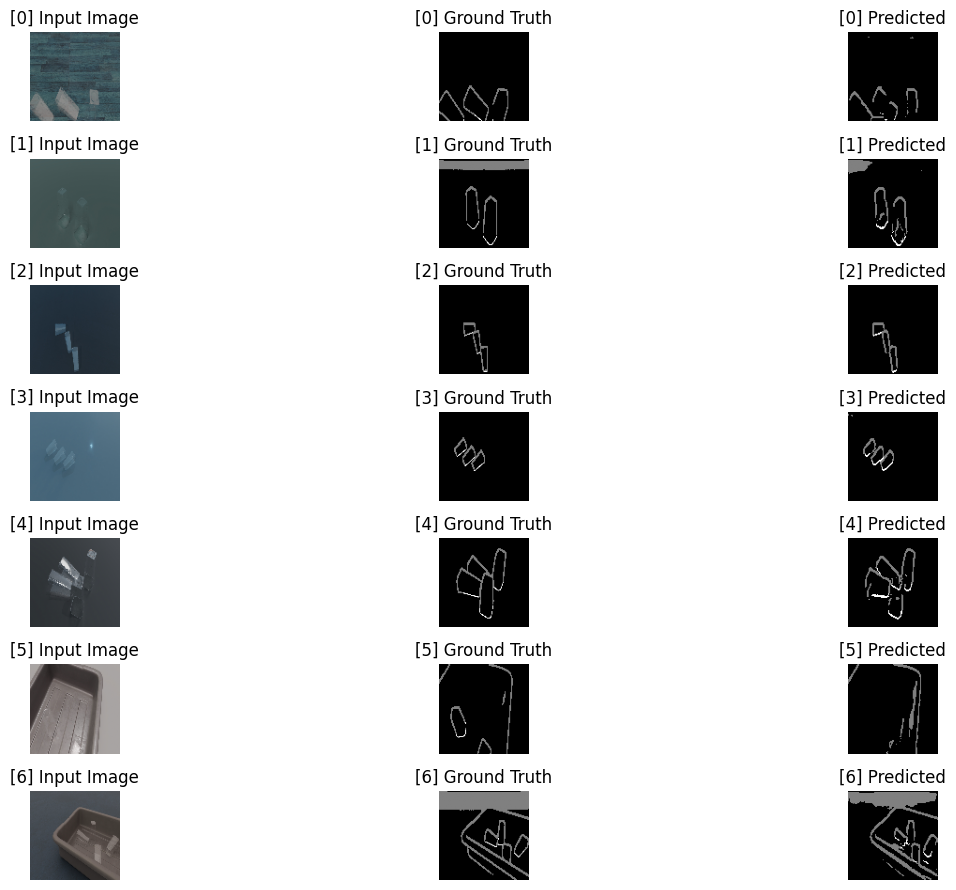

In [16]:
#각 배치별로 예측
import matplotlib.pyplot as plt
import numpy as np

# 예측
X_sample, Y_true = val_gen[0]            # 첫 배치
Y_pred = model.predict(X_sample)         # 예측 결과

n = 7  # 몇 개 시각화할지 설정 (최대 배치 크기보다 작게)

plt.figure(figsize=(15, 9))  # figure 크기 조절
for i in range(n):
    # 원본 이미지
    plt.subplot(n, 3, i*3 + 1)
    plt.imshow(X_sample[i])
    plt.title(f"[{i}] Input Image")
    plt.axis('off')

    # Ground Truth 마스크
    plt.subplot(n, 3, i*3 + 2)
    plt.imshow(Y_true[i].squeeze(), cmap='gray')
    plt.title(f"[{i}] Ground Truth")
    plt.axis('off')

    # 예측 마스크 (클래스 수에 따라 처리)
    pred_mask = np.argmax(Y_pred[i], axis=-1) if Y_pred.shape[-1] > 1 else (Y_pred[i].squeeze() > 0.5).astype('uint8')
    plt.subplot(n, 3, i*3 + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title(f"[{i}] Predicted")
    plt.axis('off')

plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


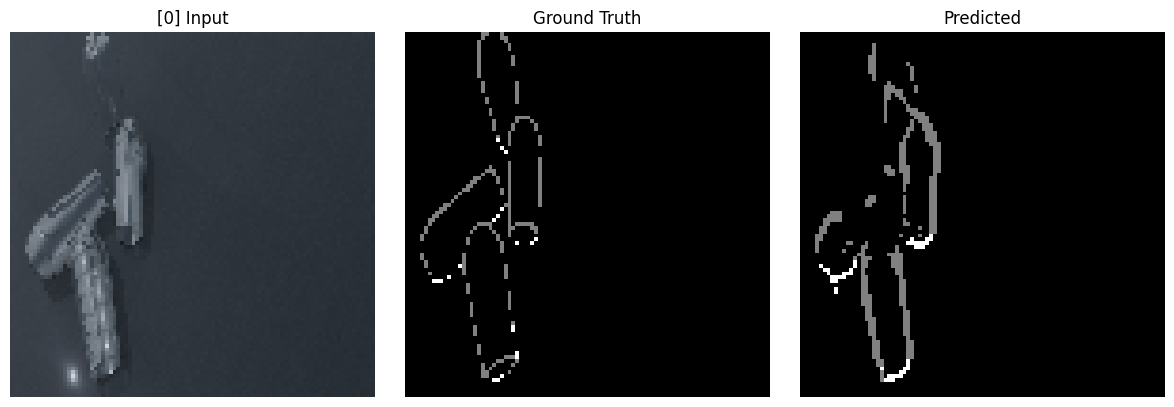

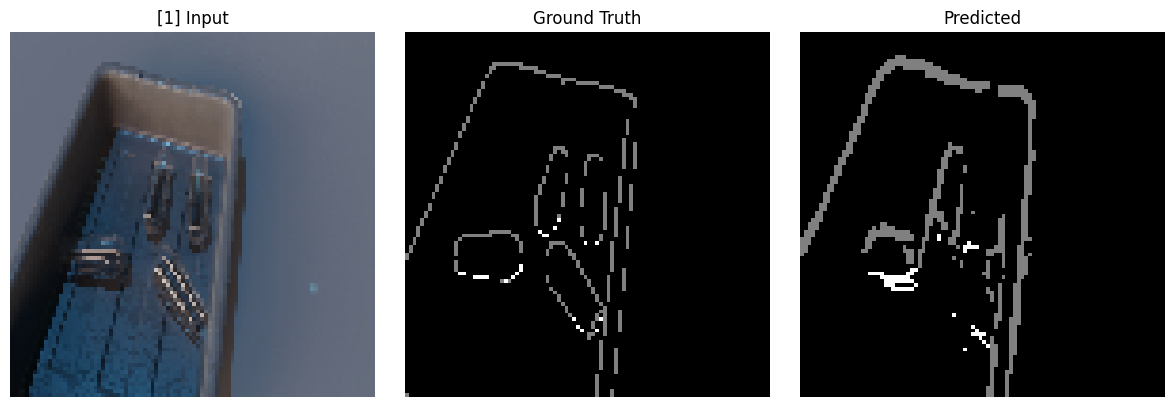

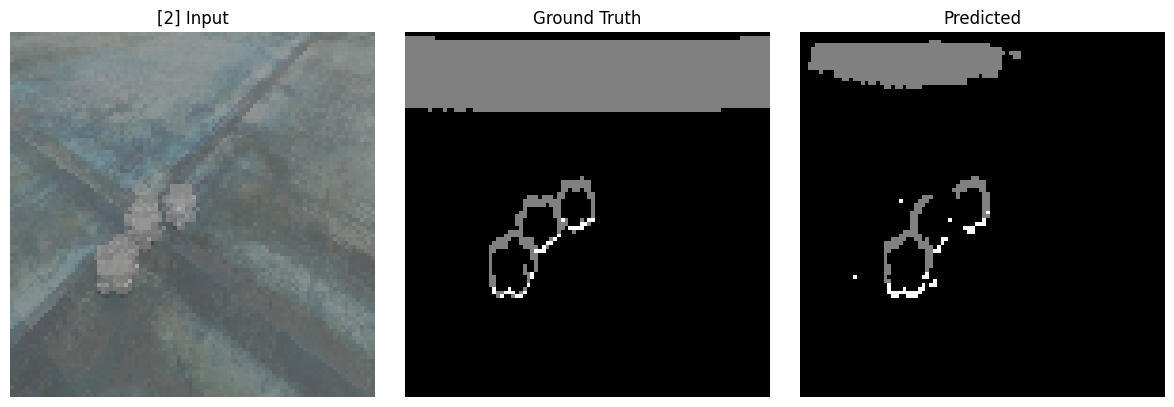

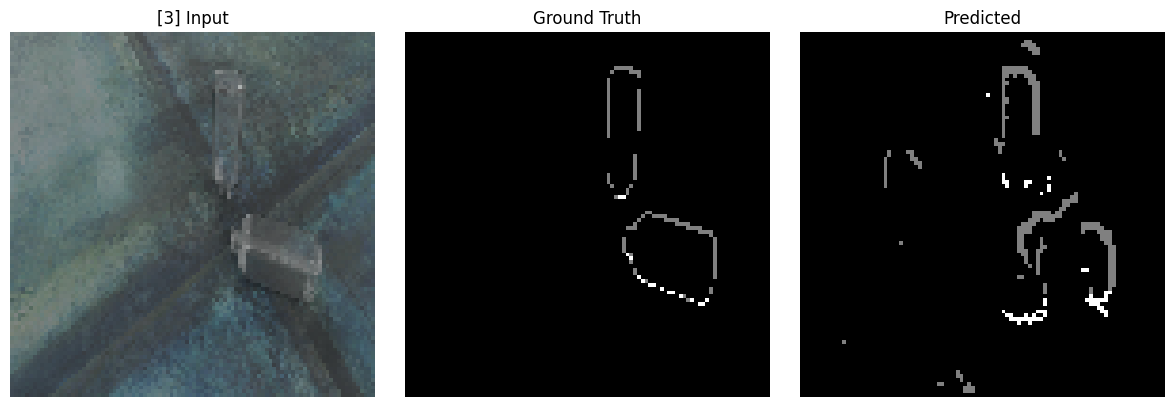

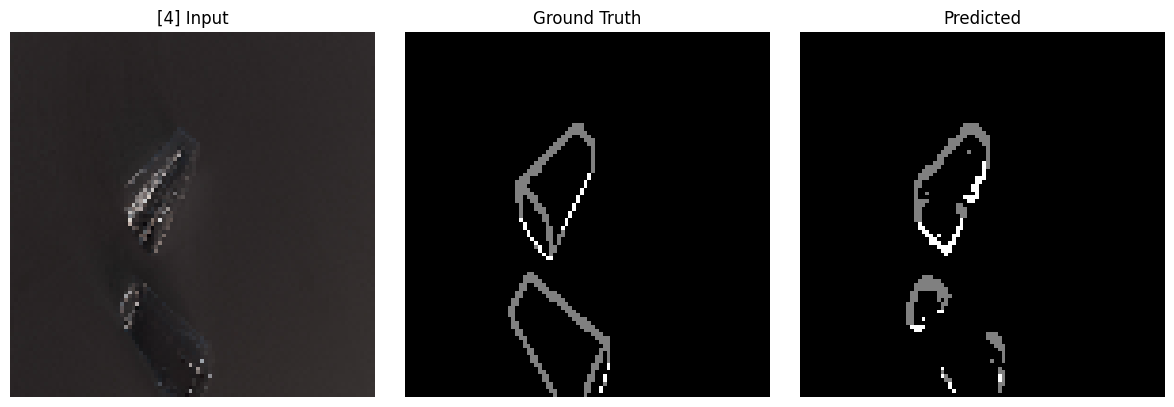

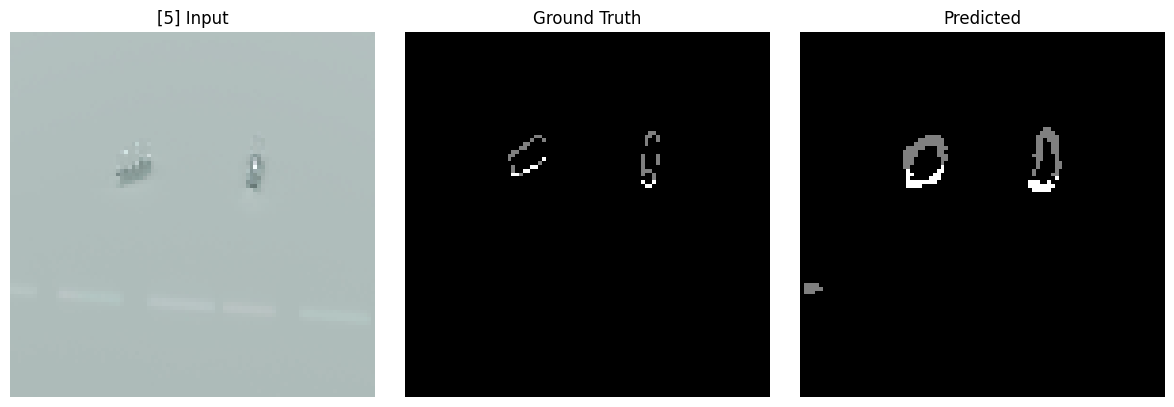

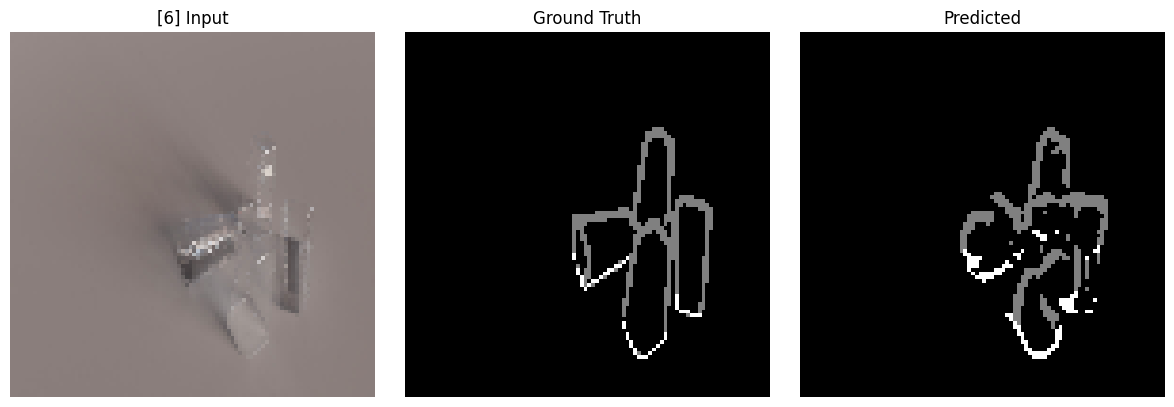

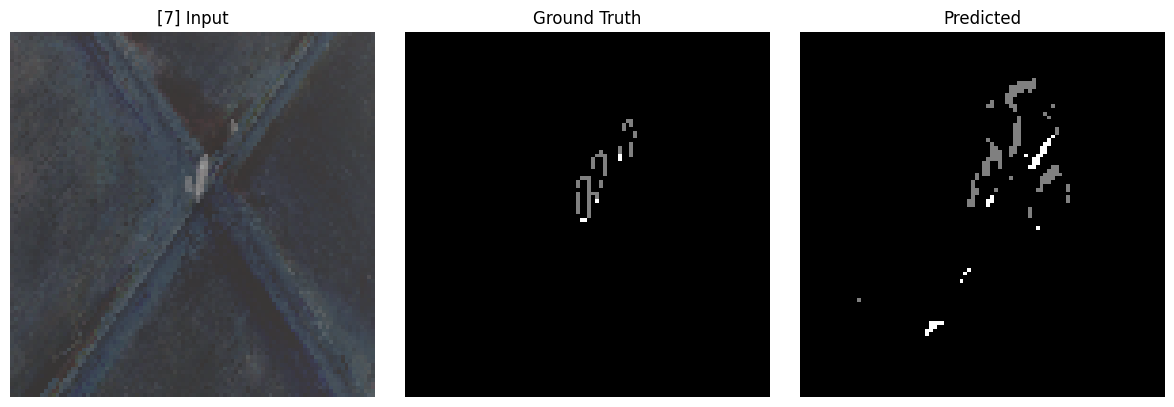

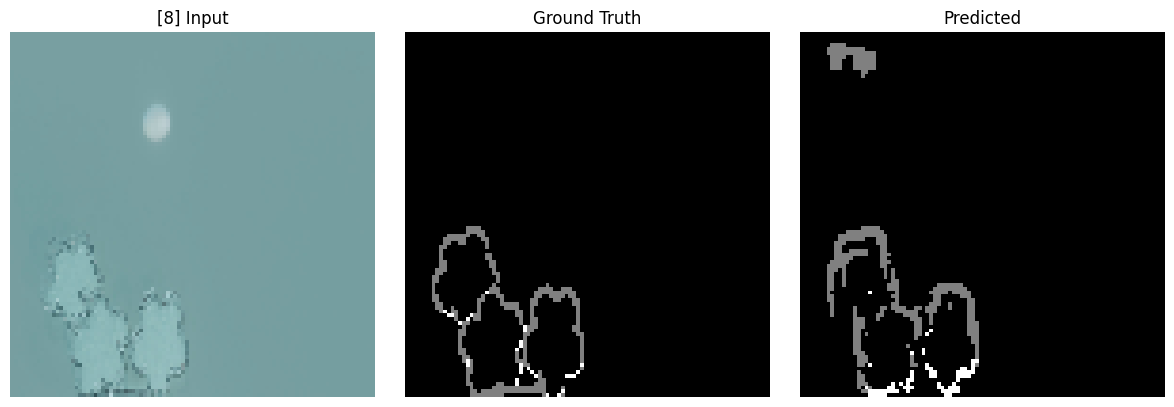

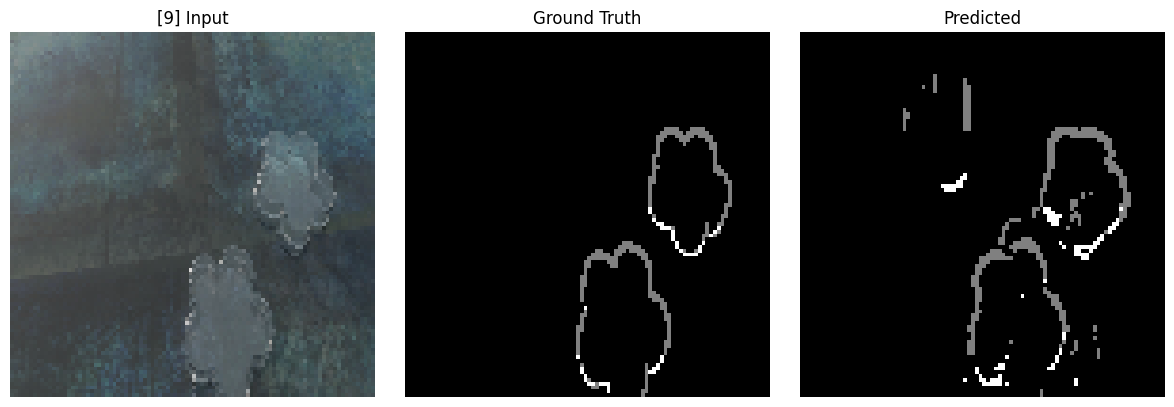

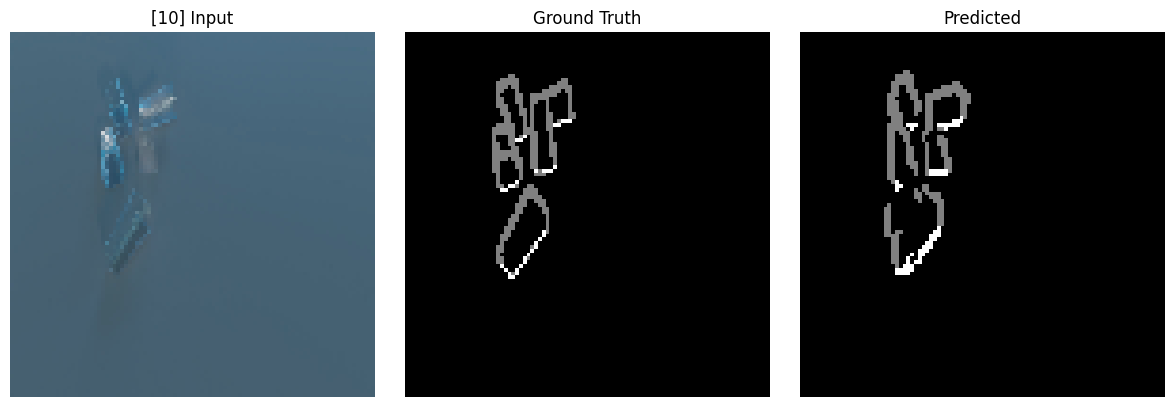

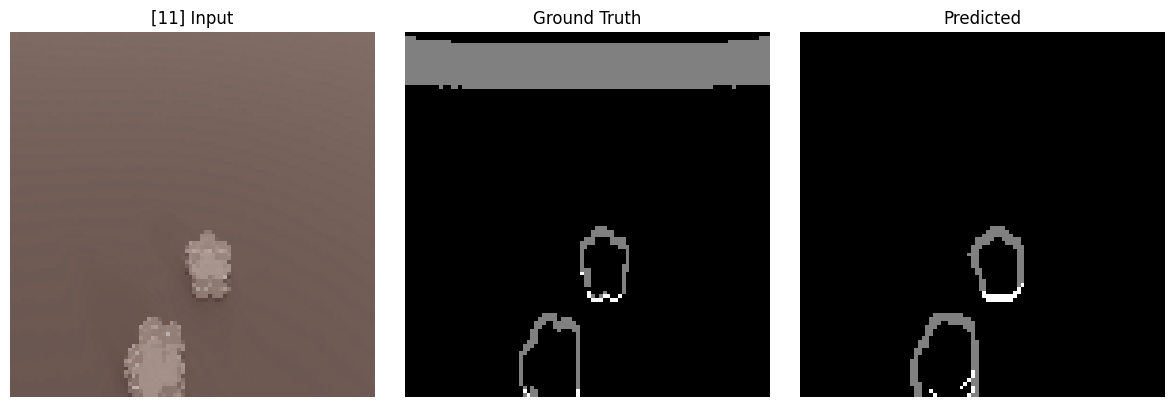

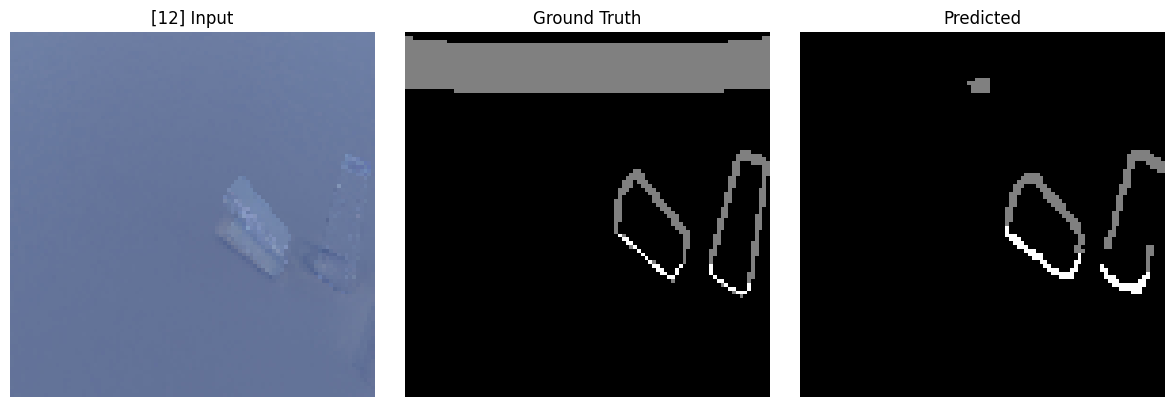

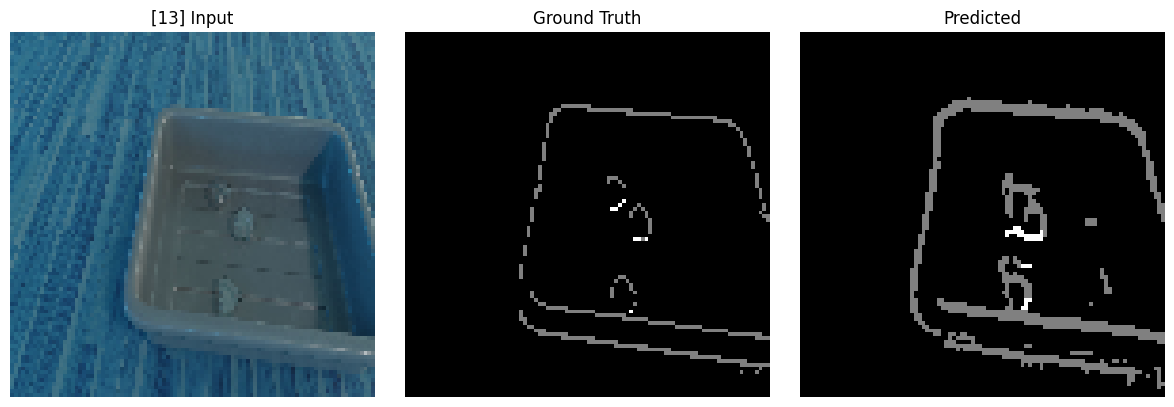

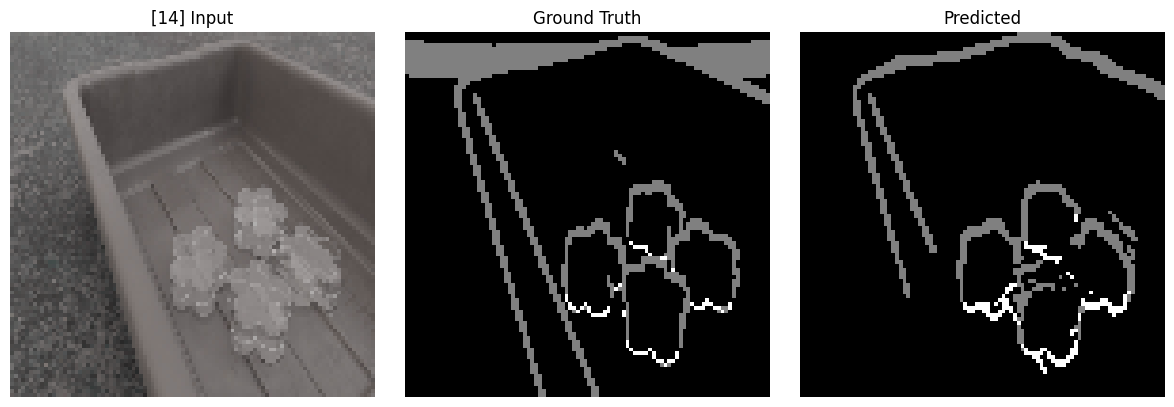

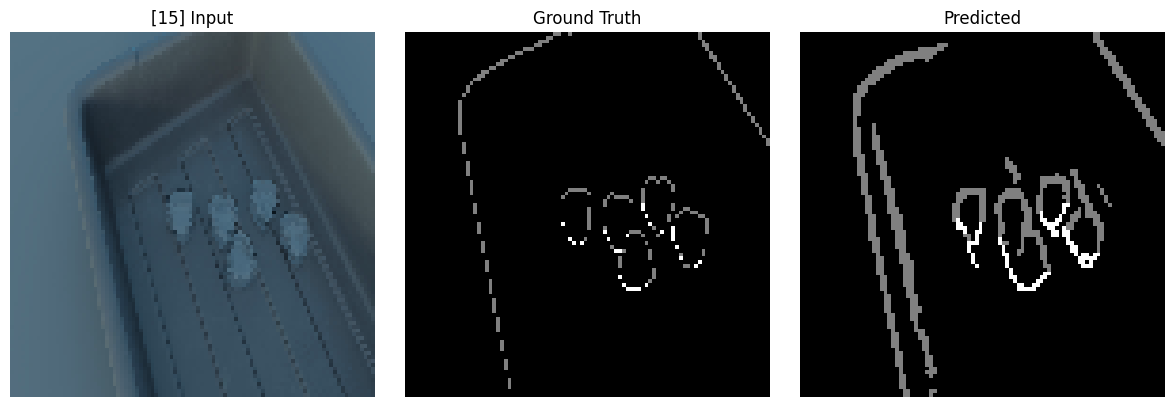

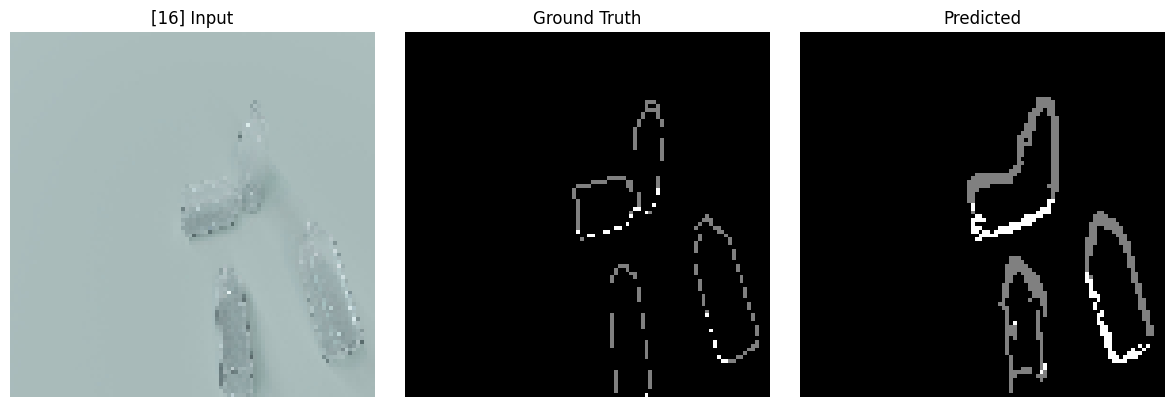

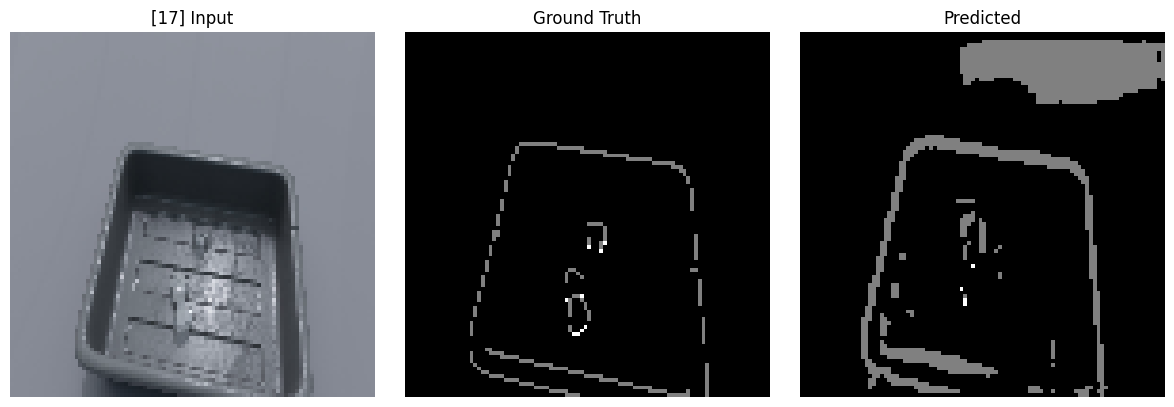

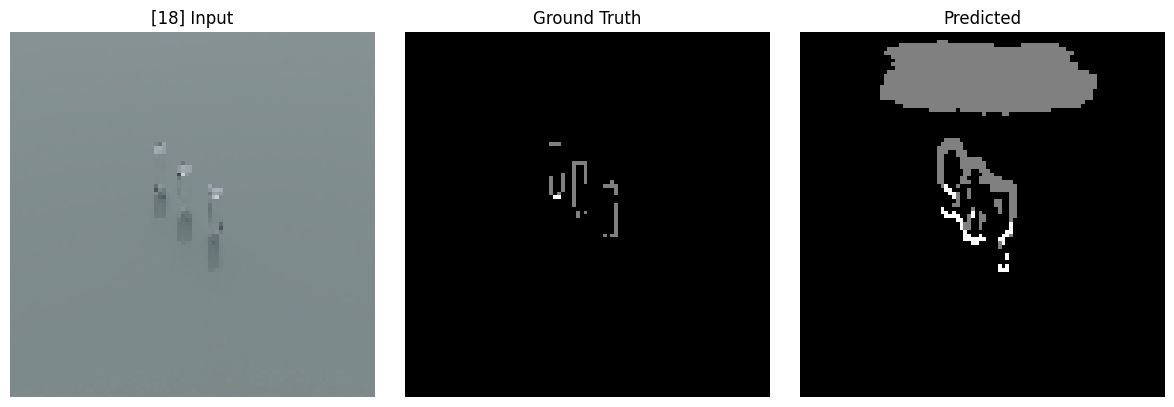

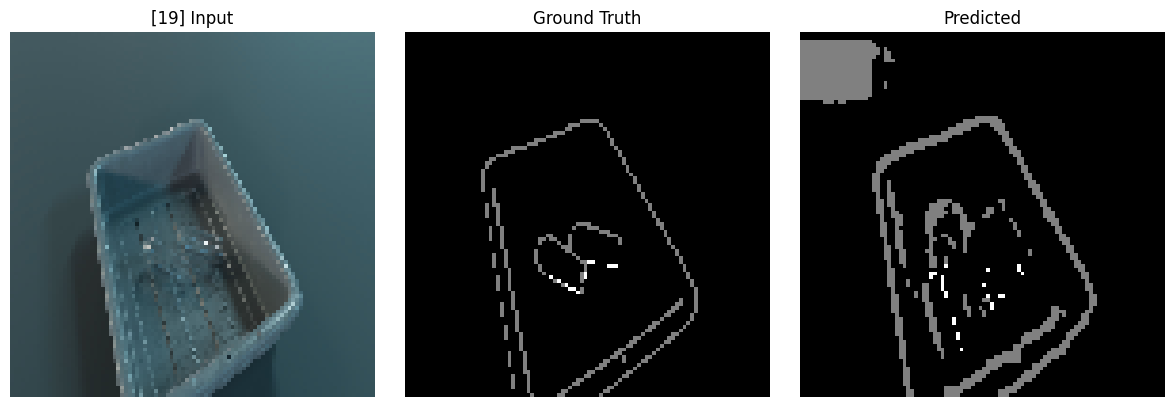

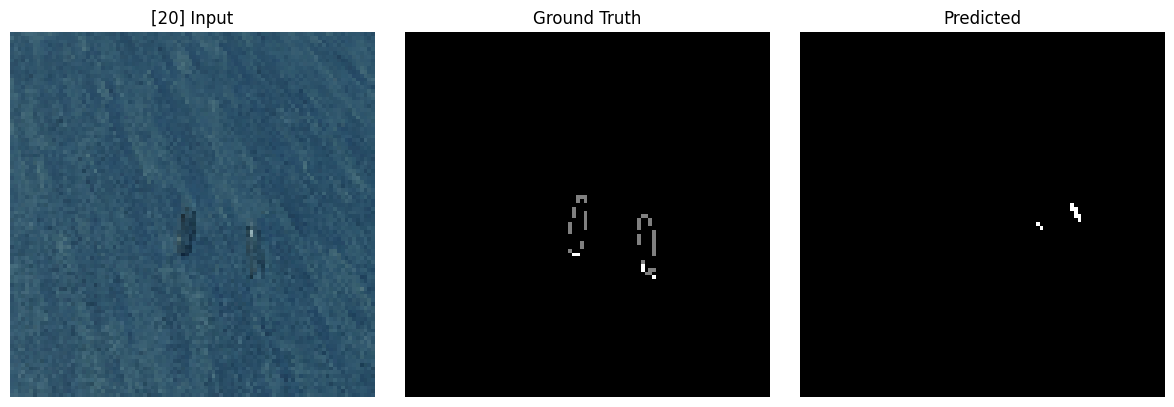

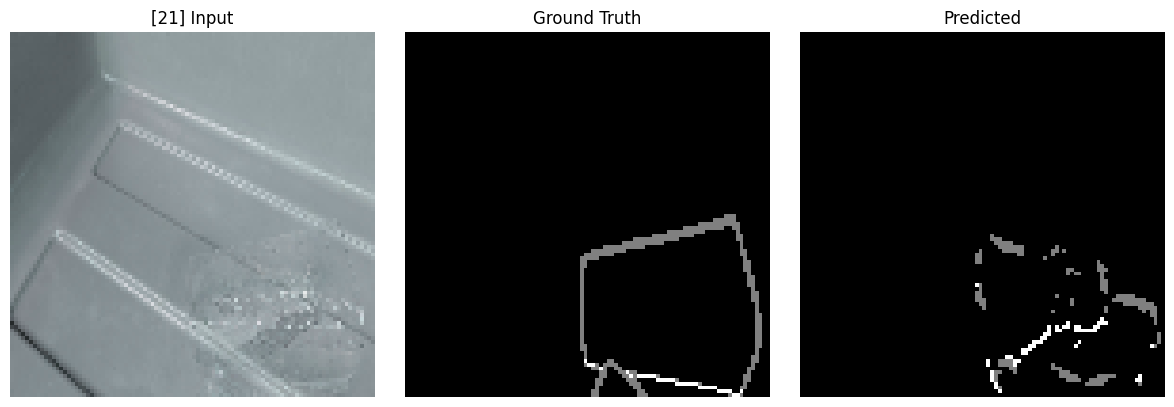

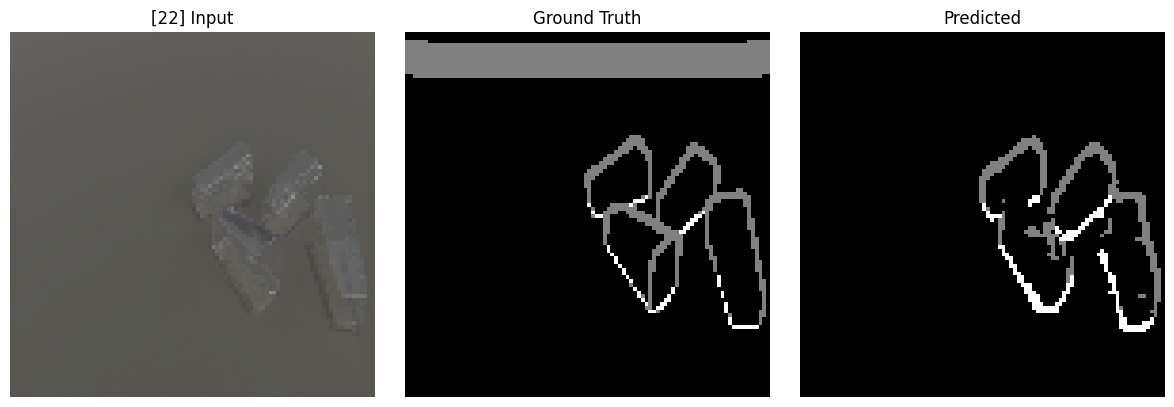

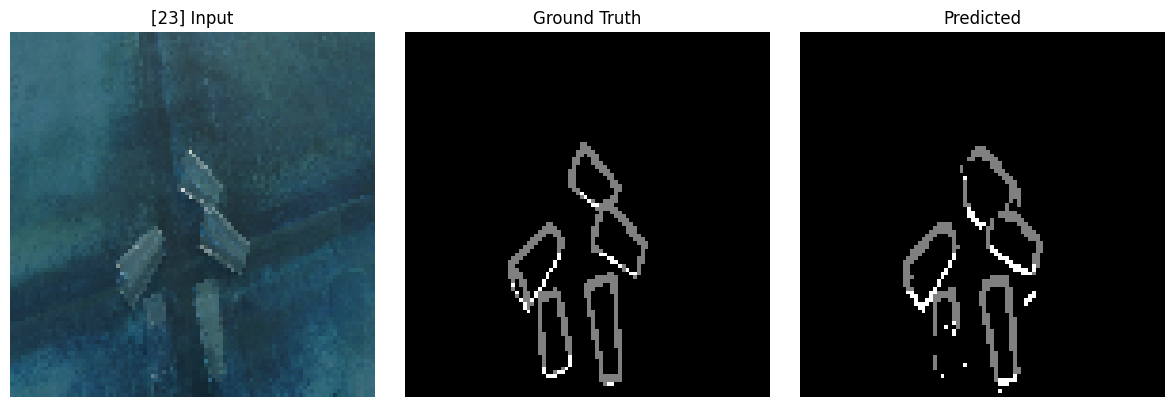

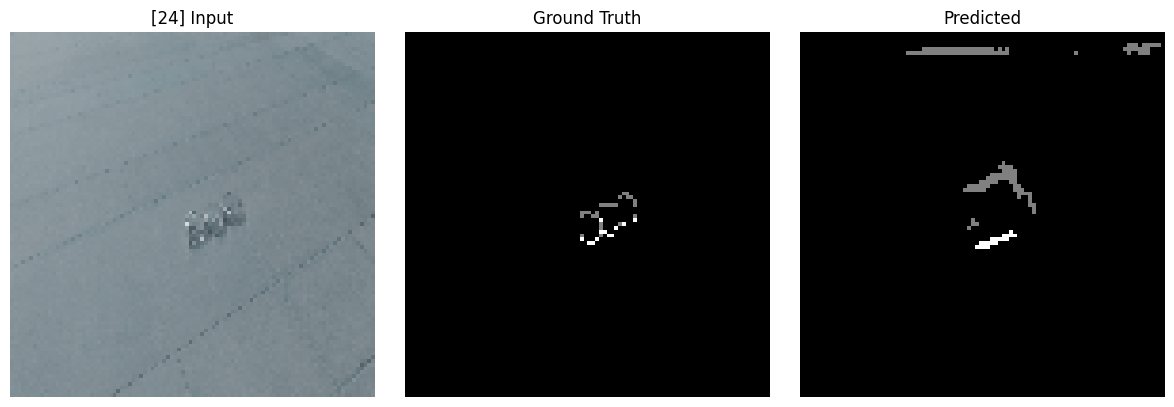

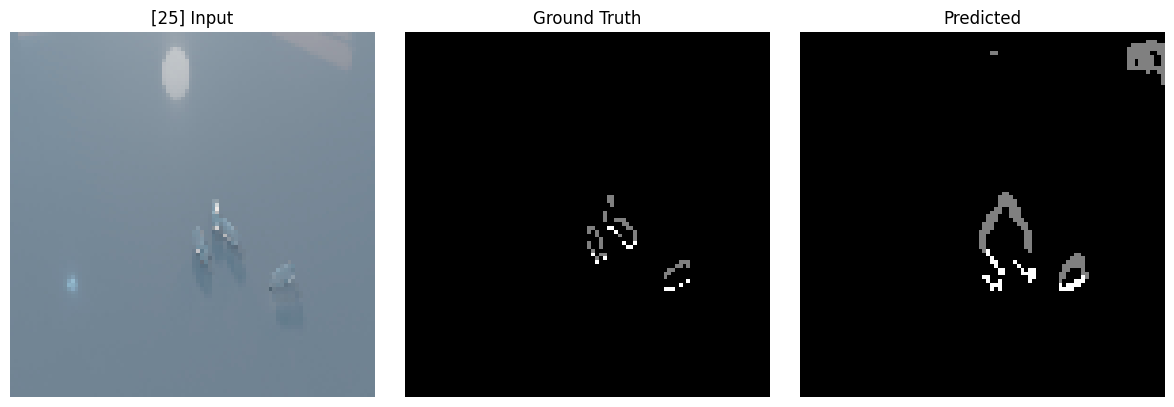

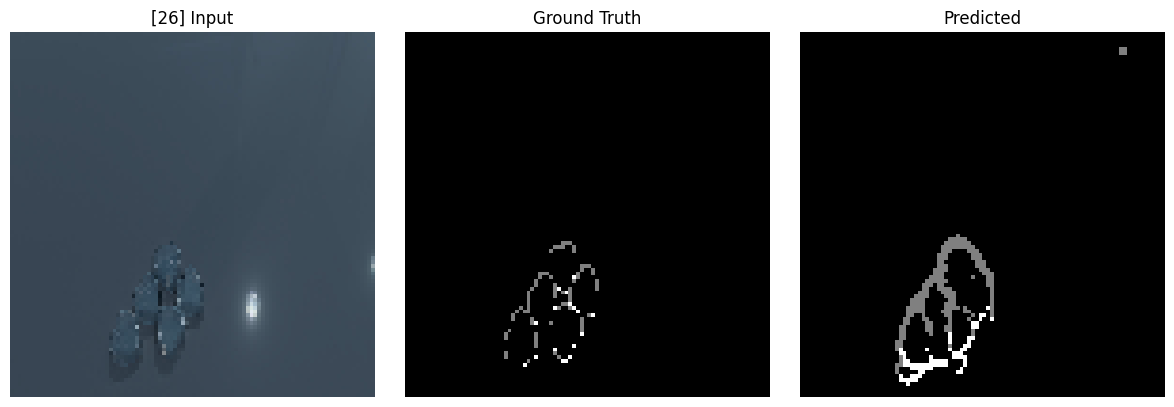

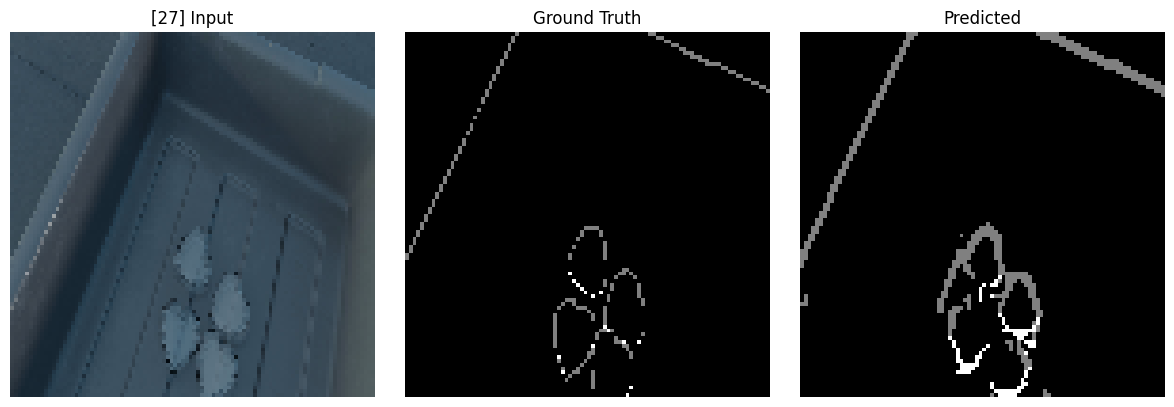

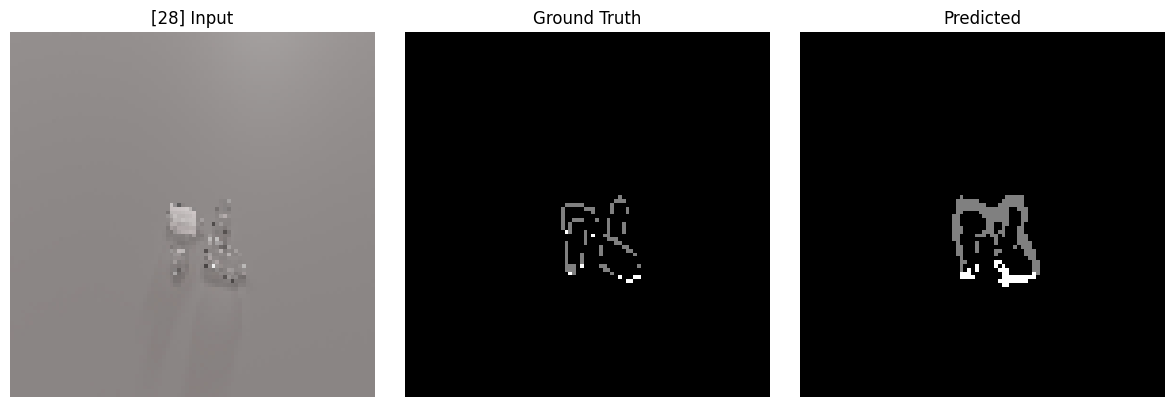

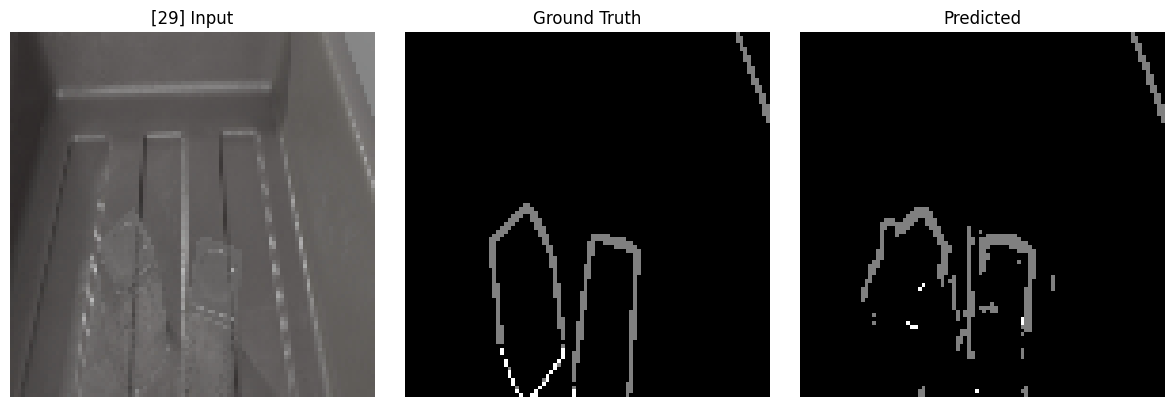

In [17]:
#랜덤 n개 출력 후 결과 예측 시각화
import random

# 전체 validation 샘플 수
all_X = []
all_Y = []
for batch_idx in range(len(val_gen)):
    X_batch, Y_batch = val_gen[batch_idx]
    all_X.append(X_batch)
    all_Y.append(Y_batch)

X_all = np.concatenate(all_X)
Y_all = np.concatenate(all_Y)

# 랜덤 샘플 k개 선택
k = 30
indices = random.sample(range(len(X_all)), k)
X_sample = X_all[indices]
Y_true = Y_all[indices]
Y_pred = model.predict(X_sample)

# 시각화 반복문
import matplotlib.pyplot as plt
import numpy as np

for i in range(len(X_sample)):
    plt.figure(figsize=(12, 4))

    # 입력 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(X_sample[i])
    plt.title(f"[{i}] Input")
    plt.axis('off')

    # GT 마스크
    plt.subplot(1, 3, 2)
    plt.imshow(Y_true[i].squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # 예측 마스크 (다중 클래스)
    pred_mask = np.argmax(Y_pred[i], axis=-1)
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



결과 요약

Accuracy	전체 픽셀 중 정답 맞춘 비율

Per-class IoU	각 클래스(배경, 접촉, 폐색)의 IoU (intersection over union)

Mean IoU	세 클래스 평균 IoU

F1-score	각 클래스에 대한 정밀도-재현율 기반 조화 평균

*배경비율이 높기때문에, Occlusion과 Contact의 Iou를 봐야함.

In [18]:
#지표 계산 함수 설정하기

from sklearn.metrics import confusion_matrix
import numpy as np

def compute_segmentation_metrics(y_true, y_pred, num_classes=3):
    """
    y_true, y_pred: shape (H, W), 정수형 라벨. 예: 0=배경, 1=occlusion, 2=contact
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    acc = np.trace(cm) / np.sum(cm)

    ious = []
    for i in range(num_classes):
        TP = cm[i, i]
        FP = cm[:, i].sum() - TP
        FN = cm[i, :].sum() - TP
        denom = TP + FP + FN
        iou = TP / denom if denom > 0 else 0
        ious.append(iou)

    mean_iou = np.mean(ious)

    return acc, ious, mean_iou


In [19]:
# 예측결과 비교
# 배치 예측
X_batch, Y_true = val_gen[0]  # (B, H, W, 1)
Y_pred = model.predict(X_batch)  # (B, H, W, C)
Y_pred_label = np.argmax(Y_pred, axis=-1)  # (B, H, W)

# 지표 계산 (0번째 이미지 기준 예시)
acc, ious, miou = compute_segmentation_metrics(Y_true[0].squeeze(), Y_pred_label[0])

print(f"엣지 분할 평가 결과 (1개 샘플)")
print(f"Accuracy         : {acc:.4f}")
print(f"IoU (배경)       : {ious[0]:.4f}")
print(f"IoU (Occlusion)  : {ious[1]:.4f}")
print(f"IoU (Contact)    : {ious[2]:.4f}")
print(f"Mean IoU         : {miou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
엣지 분할 평가 결과 (1개 샘플)
Accuracy         : 0.9659
IoU (배경)       : 0.9657
IoU (Occlusion)  : 0.4115
IoU (Contact)    : 0.0000
Mean IoU         : 0.4591


In [20]:
#전체 배치 평가
ious_all = []
for i in range(len(Y_true)):
    acc_i, ious_i, miou_i = compute_segmentation_metrics(Y_true[i].squeeze(), Y_pred_label[i])
    ious_all.append(ious_i)

ious_all = np.array(ious_all)
mean_ious = np.mean(ious_all, axis=0)

print(f"전체 배치 평균 IoU")
print(f"IoU (배경)       : {mean_ious[0]:.4f}")
print(f"IoU (Occlusion)  : {mean_ious[1]:.4f}")
print(f"IoU (Contact)    : {mean_ious[2]:.4f}")
print(f"Mean IoU         : {np.mean(mean_ious):.4f}")


전체 배치 평균 IoU
IoU (배경)       : 0.9464
IoU (Occlusion)  : 0.5166
IoU (Contact)    : 0.2468
Mean IoU         : 0.5699


In [ ]:
# 전체 모델 저장 (구조 + 가중치)
model.save('edge_segmentation_model.h5')  # 또는 .keras 확장자도 가능

In [ ]:
#모델 불러오기
from tensorflow.keras.models import load_model

# 커스텀 loss 사용한 경우는 custom_objects로 등록
model = load_model('edge_segmentation_model.h5', custom_objects={'loss_fn': loss_fn})

In [ ]:
#예측이미지 저장
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 저장 경로 설정
save_dir = '/content/predicted_edges'
os.makedirs(save_dir, exist_ok=True)

# 전체 validation 데이터 가져오기
for batch_idx in range(len(val_gen)):
    X_batch, Y_true_batch = val_gen[batch_idx]
    Y_pred_batch = model.predict(X_batch)

    for i in range(len(X_batch)):
        idx = batch_idx * val_gen.batch_size + i

        # 입력 이미지 저장 (원본 RGB)
        input_img = (X_batch[i] * 255).astype(np.uint8)
        input_path = os.path.join(save_dir, f'{idx:04d}_input.png')
        cv2.imwrite(input_path, cv2.cvtColor(input_img, cv2.COLOR_RGB2BGR))

        # 정답 마스크 저장 (0~2 → 컬러맵)
        gt_mask = Y_true_batch[i].squeeze().astype(np.uint8)
        gt_color = cv2.applyColorMap((gt_mask * 127).astype(np.uint8), cv2.COLORMAP_JET)
        gt_path = os.path.join(save_dir, f'{idx:04d}_gt.png')
        cv2.imwrite(gt_path, gt_color)

        # 예측 마스크 저장
        if Y_pred_batch.shape[-1] > 1:
            pred_mask = np.argmax(Y_pred_batch[i], axis=-1)
        else:
            pred_mask = (Y_pred_batch[i].squeeze() > 0.5).astype(np.uint8)

        pred_color = cv2.applyColorMap((pred_mask * 127).astype(np.uint8), cv2.COLORMAP_JET)
        pred_path = os.path.join(save_dir, f'{idx:04d}_pred.png')
        cv2.imwrite(pred_path, pred_color)
